In [3]:
%cd "~/projects/spartDM"
%load_ext autoreload
%autoreload 2

import os

print(f"Current working dir: {os.getcwd()}")

/home/kdang/projects/spartDM
Current working dir: /home/kdang/projects/spartDM


/home/kdang/projects/spartDM/.venv/lib/python3.10/site-packages/IPython/core/magics/osm.py:393: UserWarning: This is now an optional IPython functionality, using bookmarks requires you to install the `pickleshare` library.
  bkms = self.shell.db.get('bookmarks', {})
/home/kdang/projects/spartDM/.venv/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


# Example from scikit-learn

In [74]:
from sklearn import svm
import numpy as np
import matplotlib.pyplot as plt

# Generate training data (inliers)
X_train = 0.3 * np.random.randn(100, 2)
X_train = np.r_[X_train + 2, X_train - 2]

# Generate test data (inliers and outliers)
X_test = 0.3 * np.random.randn(20, 2)
X_test = np.r_[X_test + 2, X_test - 2]
X_outliers = np.random.uniform(low=-4, high=4, size=(20, 2))

# Fit the One-Class SVM
clf = svm.OneClassSVM(kernel="rbf", gamma=0.1, nu=0.05)
clf.fit(X_train)


,kernel,'rbf'
,degree,3
,gamma,0.1
,coef0,0.0
,tol,0.001
,nu,0.05
,shrinking,True
,cache_size,200
,verbose,False
,max_iter,-1


In [12]:
clf.support_vectors_.shape
clf.support_.shape
clf.dual_coef_

array([[1.        , 0.7116573 , 0.31784923, 1.        , 1.        ,
        1.        , 1.        , 1.        , 0.61761368, 0.32366403,
        0.00637338, 1.        , 0.02284238, 1.        ]])

In [ ]:

# Predict
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)
y_pred_outliers = clf.predict(X_outliers)

# -1 for outliers, 1 for inliers
print("Train outlier count:", np.sum(y_pred_train == -1))
print("Test outlier count:", np.sum(y_pred_test == -1))
print("True outliers detected:", np.sum(y_pred_outliers == -1))

xx, yy = np.meshgrid(np.linspace(-5, 5, 500), np.linspace(-5, 5, 500))
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.title("One-Class SVM")
plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), 0, 7), cmap=plt.cm.PuBu)
plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors="darkred")
plt.scatter(X_train[:, 0], X_train[:, 1], c="white", s=20, edgecolors="k", label="x_train")
plt.scatter(X_test[:, 0], X_test[:, 1], c="blue", s=20, edgecolors="k", label="x_test")
plt.scatter(X_outliers[:, 0], X_outliers[:, 1], c="gold", s=20, edgecolors="k", label="x_outlier")
plt.xlim((-5, 5))
plt.ylim((-5, 5))
# plt.grid()
plt.legend()
plt.show()


# Prequisitions

## Helper functions

In [90]:
import numpy as np
from src.data.datamodules.starmen import StarmenDataset
from monai.data import DataLoader
from src.sadm.utils import plot_multi_imgs
from src.utils.metrics import percnorm, mse, mae
import json
import torch
import torch.nn.functional as F
from monai.transforms import ScaleIntensity
from einops import rearrange, repeat
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from src.utils.visualization import filter_gt_ano_region
import torchvision
from src.utils.visualization import plot_comparison_starmen, plot_kde_pixel, draw_featmap
from src.ldae.utils import heat_map, feature_distance, patchify
from src.ldae.modules.ocsvm import standardize
from sklearn import svm
import seaborn as sns
import pandas as pd

from functools import partial

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Constant variables and helper functions

DATA_DIR = "data/starmen/output_random_noacc"
WORK_DIR = "workdir/diffae_starmen"


# Helper function to quick plot a tensor using torchvision grid
def quick_plot_tensor(x, title, normalize=True):
    """
    x: torch.tensor of size(B, C, H, W)
    """
    if isinstance(x, np.ndarray):
        x = torch.tensor(x, dtype=torch.float32)
    grid = torchvision.utils.make_grid(x, nrow=10, normalize=normalize, padding=1)  # noqa: F821
    plt.figure(figsize=(16, 4))  
    plt.imshow(grid.permute(1, 2, 0).squeeze(), cmap='gray')
    plt.title(title)
    plt.axis("off")

def convert_to_torch(x, add_color_channel=True, device=torch.device("cpu")):
    """
    convert a numpy array to torch.Tensor with option to add C channel
    """
    if add_color_channel:
        x = rearrange(x, "b h w -> b 1 h w")
    x = torch.tensor(x, dtype=torch.float32).to(device)
    return x

to_torch = partial(torch.tensor, dtype=torch.float32, device=device)


In [5]:
"""
Load test dataset
Returns: dict
"""

import json


def load_test_dataset(split="growing_circle20"):

    infer_dir = os.path.join(WORK_DIR, "infer", f"{split}_ddim100_noise250")

    # Test dataset
    test_ds = StarmenDataset(
    data_dir=DATA_DIR,
    split=split,
    nb_subject=None,
)
    test_loader = DataLoader(test_ds, batch_size=1, shuffle=True, num_workers=1)
    print(f"Len of {split} dataset: {len(test_loader)}")


    # Read the reconstruction error files to get the index and corresponding reonconstruction image
    try: 
        eval_result_file = os.path.join(infer_dir, "results", "eval_dict.json")
        with open(eval_result_file, "r") as f:
            eval_dict = json.load(f)
        test_ids = eval_dict["IDs"]
    # test_ids = np.load(recons_idx_path)
    # test_ids = test_ids.squeeze().tolist()
    except FileNotFoundError:
        test_ids = test_ds.ids

    # Load the original (anomalious) image from test dataset by index
    x_orgs = [test_ds.get_images_by_id(id)["img"].squeeze() for id in test_ids]
    x_orgs = np.stack(x_orgs).astype("float32")

    # Load the groundtruth anomaly mask 
    x_ano_gts = []
    for id in test_ds.ids:
        x_ano_gt = test_ds.get_images_by_id(id)["anomaly_gt_seg"]

        if x_ano_gt is None:
            break
        else:
            x_ano_gts.append(x_ano_gt.squeeze())

    if len(x_ano_gts) > 0: 
        x_ano_gts = np.stack(x_ano_gts).astype("float32")
        x_ano_gts.shape

    # Load the original healthy images
    # healthy path example= data/starmen/output_random_noacc/images/SimulatedData__Reconstruction__starman__subject_s0__tp_0.npy
    x_hts = []
    for id in test_ids:
        for t in range(0, 10):
            ht_path = os.path.join(DATA_DIR, "images", f"SimulatedData__Reconstruction__starman__subject_s{id}__tp_{t}.npy")
            ht = np.load(ht_path)
            x_hts.append(ht)
    x_hts = np.stack(x_hts)
    x_hts = rearrange(x_hts, "(b t) h w -> b t h w", t=10)
    x_hts.shape

    # add C dimension
    x_orgs = rearrange(x_orgs, "b t h w -> b t 1 h w")
    if len(x_ano_gts) > 0:
        x_ano_gts = rearrange(x_ano_gts, "b t h w -> b t 1 h w")
    x_hts = rearrange(x_hts, "b t h w -> b t 1 h w")

    try:
        # Load reconstruction - xT_inferred
        x_recons = np.load(os.path.join(infer_dir, "results", "recons.npy"))
        x_recons.shape

        # Load reconstruction - from random noise
        x_recons_semantic = np.load(os.path.join(infer_dir, "results", "recons_semantic.npy"))
        x_recons_semantic.shape
    except FileNotFoundError: 
        x_recons, x_recons_semantic = None, None

    # convert to torch
    x_orgs = to_torch(x_orgs) if not isinstance(x_orgs, torch.Tensor) else x_orgs
    x_hts = to_torch(x_hts) if not isinstance(x_hts, torch.Tensor) else x_hts
    x_ano_gts = to_torch(x_ano_gts) if not isinstance(x_ano_gts, torch.Tensor) else x_ano_gts
    if x_recons is not None and x_recons_semantic is not None: 
        x_recons = to_torch(x_recons) if not isinstance(x_recons, torch.Tensor) else x_recons
        x_recons_semantic = to_torch(x_recons_semantic) if not isinstance(x_recons_semantic, torch.Tensor) else x_recons_semantic

    return {
        "x_orgs": x_orgs,
        "x_hts": x_hts,
        "x_ano_gts": x_ano_gts,
        "x_recons": x_recons,
        "x_recons_semantic": x_recons_semantic,
    }

## Load model


In [6]:
# Fine-tuned feature extractor model

from src.ldae import CondDDPM, FeatureExtractorLitmodel
from lightning.pytorch.utilities.model_summary import ModelSummary


## Load model
ckpt_path = os.path.join(WORK_DIR, "fe-train", "checkpoints", "best.ckpt")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

diffae_litmodel = FeatureExtractorLitmodel.load_from_checkpoint(ckpt_path, map_location=device)

ema_encoder = diffae_litmodel.encoder
ema_encoder.eval()
ema_decoder = diffae_litmodel.unet
ema_decoder.eval()
fe = diffae_litmodel.fe
fe = fe.float()
fe.eval()

# GaussianDistribution helper class
gaussian_diffusion = diffae_litmodel.gaussian_diffusion

# Model summary

summary = ModelSummary(diffae_litmodel, max_depth=1)
print(summary)

Backbone model loaded successfully.
Frozen first 0 layers out of 161 in the backbone

Freeze ema_encoder from DDPM models.
Delete litmodel. Only keep UNet and Encoder
  | Name    | Type             | Params | Mode
----------------------------------------------------
0 | encoder | SemanticEncoder  | 24.6 M | eval
1 | unet    | CondUNet         | 2.5 M  | eval
2 | fe      | FeatureExtractor | 17.1 M | eval
----------------------------------------------------
8.5 M     Trainable params
27.1 M    Non-trainable params
35.6 M    Total params
142.422   Total estimated model params size (MB)
0         Modules in train mode
615       Modules in eval mode


### OCSVM model


In [5]:
from src.ldae.modules import OCSVM, OCSVMguidedAutoencoder

ocsvm_ckpt = torch.load(os.path.join(WORK_DIR, "ocsvm/checkpoints/best.pth"), map_location=device)
ocsvm_ckpt["info"]

use_semantic = False

if use_semantic:
    ocsvm = OCSVM(input_dim=512,
                latent_dim=16,
                ocsvm_coeff=0.1,
                nu_ocsvm_coeff=0.03,
                gamma_rbf_coeff="scale",
                batch_size_valid=100, 
                jz_mode="StopGradLoss")
else:
    ocsvm = OCSVMguidedAutoencoder(
            batch_size_train=100, 
            batch_size_valid=100,
            latent_dim=16, 
            ocsvm_coeff=0.1,
            nu_ocsvm_coeff=0.03, 
            gamma_rbf_coeff="scale", 
            jz_mode="StopGradLoss")
ocsvm.load_state_dict(ocsvm_ckpt["model_state"])

<All keys matched successfully>

In [6]:
# OneClassSVM fit model

import pickle

work_dir = "workdir/diffae_starmen/"
clf_path = os.path.join(work_dir, "ocsvm/ocsvm_fit.pkl")

with open(clf_path, "rb") as f:
    clf = pickle.load(f)

clf

print("support vector indeces [non zero]")
print(clf.support_)

print("support vectors [non zero]")
print(clf.support_vectors_.shape)

print("alpha dual-coef")
print(clf.dual_coef_)

print("rho offset")
print(clf.offset_)


support vector indeces [non zero]
[  29   65   97  181  215  218  281  290  296  316  398  399  427  478
  525  609  615  643  805  854  857  896  938  942  957  959  966  967
  968  983  988  989 1027 1028 1068 1101 1127 1142 1146 1174 1197 1239
 1277 1288 1313 1323 1429 1466 1489 1527 1528 1538 1570 1607 1654 1657
 1763 1796 1879 1899 1917 2005 2006 2039 2167 2169 2175 2226 2254 2287
 2342 2419 2423 2425 2444 2447 2512 2527 2538 2648 2649 2679 2684 2738
 2887 2929 2952 2954 2955 2959 3006 3015 3054 3057 3179 3258 3321 3323
 3324 3326 3327 3329 3381 3387 3413 3439 3467 3488 3528 3576 3609 3623
 3787 3808 3838 3839 3914 3925 3954 3955 3956 3991 4077 4109 4119 4149
 4168 4176 4229 4238 4256 4340 4347 4348 4349 4386 4411 4418 4457 4509
 4548 4549 4566 4578 4589 4632 4689 4722 4754 4775 4778 4782 4786 4859
 4928 4929 5107 5123 5174 5309 5338 5397 5429 5459 5496 5508 5548 5555
 5557 5566 5567 5595 5596 5600 5603 5604 5607 5613 5624 5625 5626 5639
 5653 5659 5737 5739 5799 5816 5829 5868 58

## Load dataset

In [7]:
# growing_circle20 dataset
out_growing_circle = load_test_dataset(split="growing_circle20")

# darker_line20 dataset
out_darker_line = load_test_dataset(split="darker_line20")

# darker_circle20 dataset
out_darker_circle = load_test_dataset(split="darker_circle20")

# test dataset
out_test = load_test_dataset(split="test")

# val dataset
out_val = load_test_dataset(split="val")

dict_keys = list(out_test.keys())
print(f"Dict keys: {dict_keys}")


Len of growing_circle20 dataset: 20
Len of darker_line20 dataset: 20
Len of darker_circle20 dataset: 20
Len of test dataset: 150
Len of val dataset: 150
Dict keys: ['x_orgs', 'x_hts', 'x_ano_gts', 'x_recons', 'x_recons_semantic']


# Image-wise anomaly OCSVM

## train dataset

In [8]:
train_ds = StarmenDataset(
data_dir=DATA_DIR,
split="train",
nb_subject=None,
)
train_loader = DataLoader(train_ds, batch_size=10, shuffle=True, num_workers=1)

len(train_loader)

out_train = load_test_dataset(split="train")

Len of train dataset: 700


### ysem analysis

In [28]:
x0 = out_train["x_orgs"]
x0 = rearrange(x0, "b t ... -> (b t) ...")
x0.shape

x_split = torch.split(x0, 200)
ysem_train = []
for x in x_split:
    with torch.no_grad():
        ysem = ema_encoder(x)
        ysem_train.append(ysem)

ysem_dict = {
    "train": torch.cat(ysem_train).cpu().numpy()
}

names = ["growing_circle", "darker_circle", "darker_line", "test"]
for i, out in enumerate([out_growing_circle, out_darker_circle, out_darker_line, out_test]):
    ysem_ls = []
    x0 = out["x_orgs"]
    x0 = rearrange(x0, "b t ... -> (b t) ...")
    if x0.shape[0] > 200: 
        x_split = torch.split(x0, 200)
    else: 
        x_split = rearrange(x0, "b c h w -> 1 b c h w")
    for x in x_split:
        with torch.no_grad():
            ysem = ema_encoder(x)
            ysem_ls.append(ysem)
    
    ysem_dict[names[i]] = torch.cat(ysem_ls).cpu().numpy()


In [30]:
# save result
import joblib
save_path = "notebooks/exp_results/ysem_dict.pkl"
joblib.dump(ysem_dict, save_path)

['notebooks/exp_results/ysem_dict.pkl']

In [220]:
# load result
save_path = "notebooks/exp_results/ysem_dict.pkl"
ysem_dict = joblib.load(save_path)
ysem_dict.keys()

dict_keys(['train', 'growing_circle', 'darker_circle', 'darker_line', 'test'])

In [221]:
# Calculate variance of each dimension
ysem_all = []
for k, v in ysem_dict.items():
    ysem_all.append(v)

ysem_all = np.concatenate(ysem_all)
ysem_all.shape
ysem_var = np.var(ysem_all, axis=0)
ysem_var.shape

top10_idx = np.argsort(-ysem_var)[:10]
top10_idx

array([277, 107, 268, 405,  80, 360, 367, 214, 400, 375])

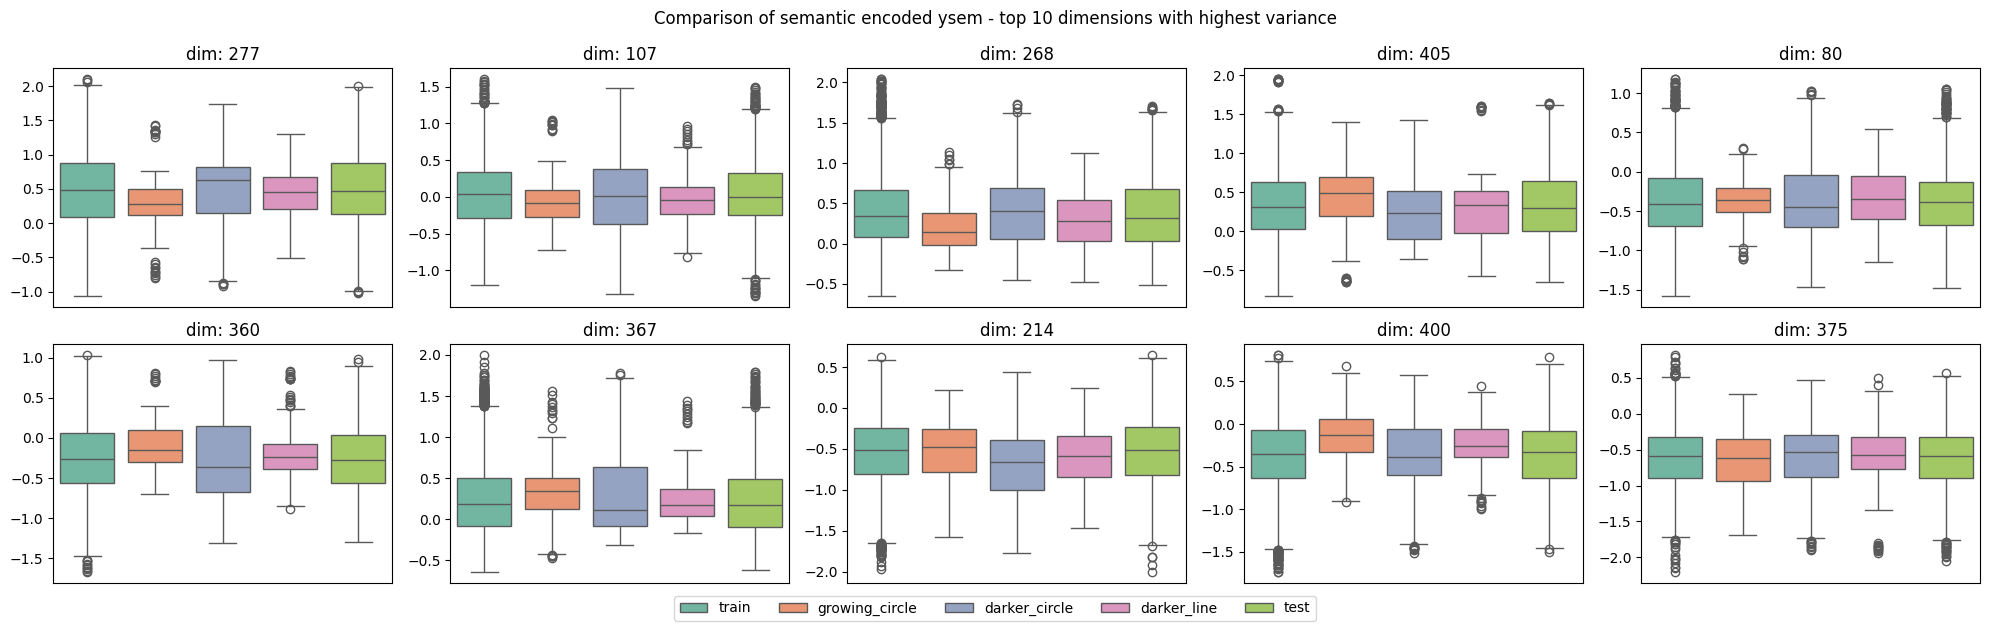

In [222]:
# Compare box plot of ysem values for top10 dimension that have the highest variance
import pandas as pd
import seaborn as sns
from matplotlib.lines import Line2D

df_list = []
for k, v in ysem_dict.items():
    df = pd.DataFrame(v, columns=[f"{i}" for i in range(v.shape[1])])
    df["type"] = k

    df_list.append(df)

df = pd.concat(df_list, ignore_index=True)
df.shape

fig, axes = plt.subplots(2, 5, figsize=(20, 6))
axes = axes.flatten()

for i, idx in enumerate(top10_idx):
    ax = axes[i]
    sns.boxplot(
        data=df,
        x="type",
        y=df.columns[idx],
        hue="type",        
        palette="Set2",        
        dodge=False,
        ax=ax,
        legend=i==0
    )
    ax.set_title(f"dim: {idx}")
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_xticks([])
    # plt.xticks([])
    # plt.xlabel("")
    # plt.ylabel("Value")

# Legends
handles, labels = axes[0].get_legend_handles_labels()
axes[0].legend_.remove()

plt.suptitle("Comparison of semantic encoded ysem - top 10 dimensions with highest variance")
plt.tight_layout()
fig.legend(handles, labels, loc='lower center', ncol=len(labels), bbox_to_anchor=(0.5, -0.05))
plt.show()

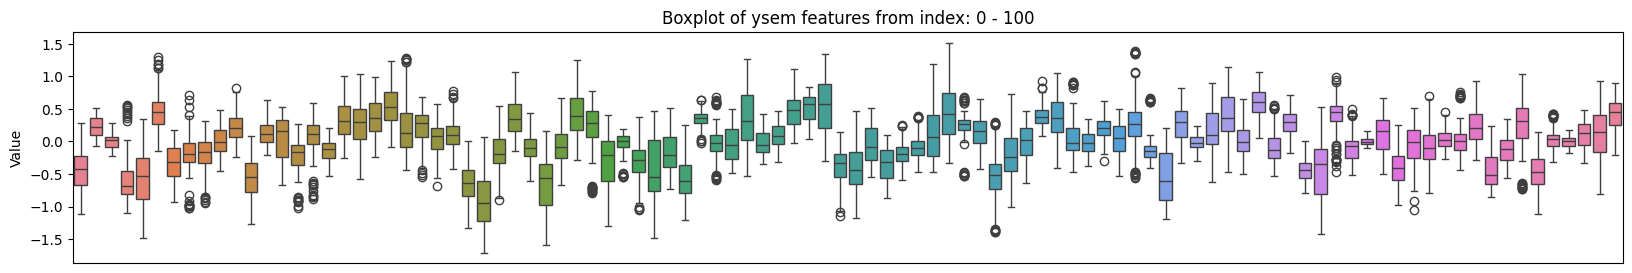

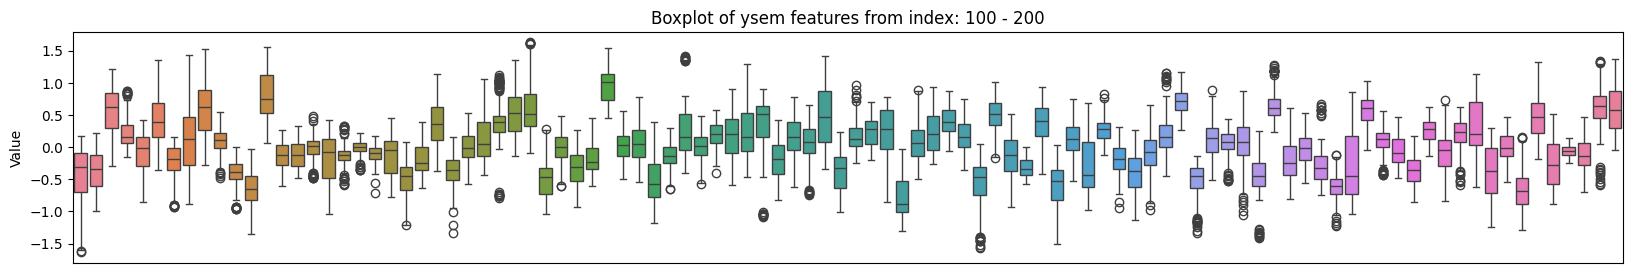

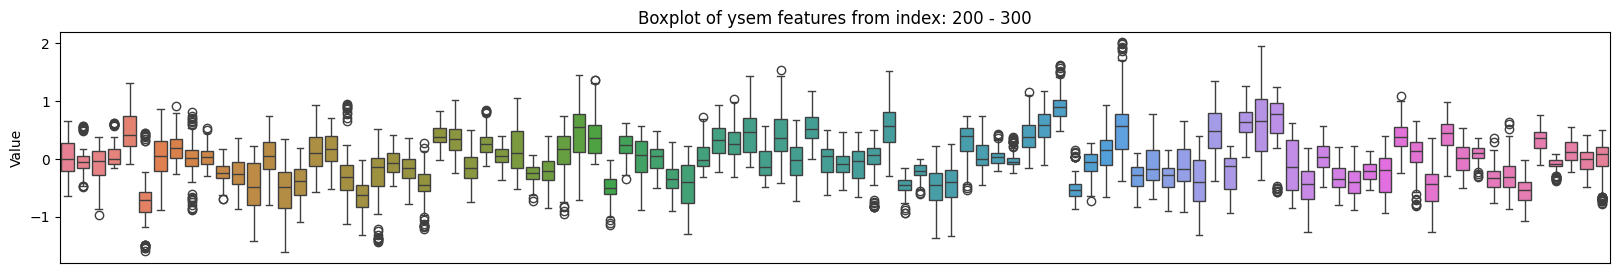

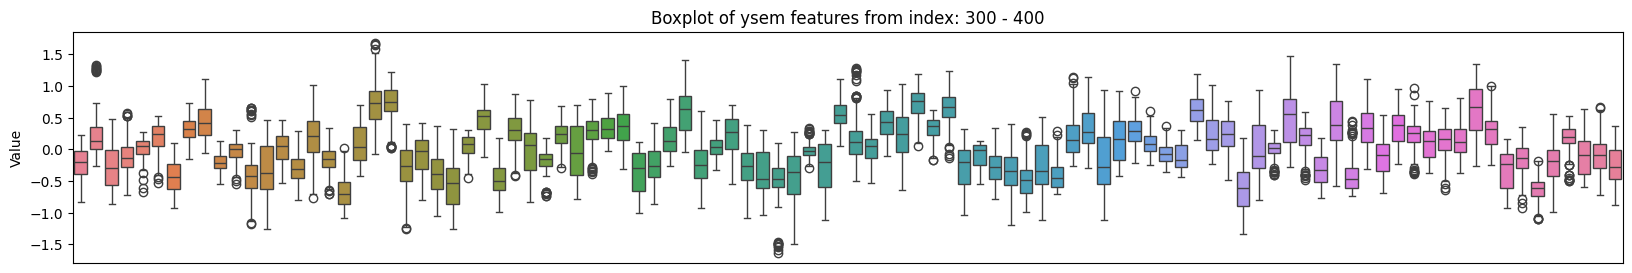

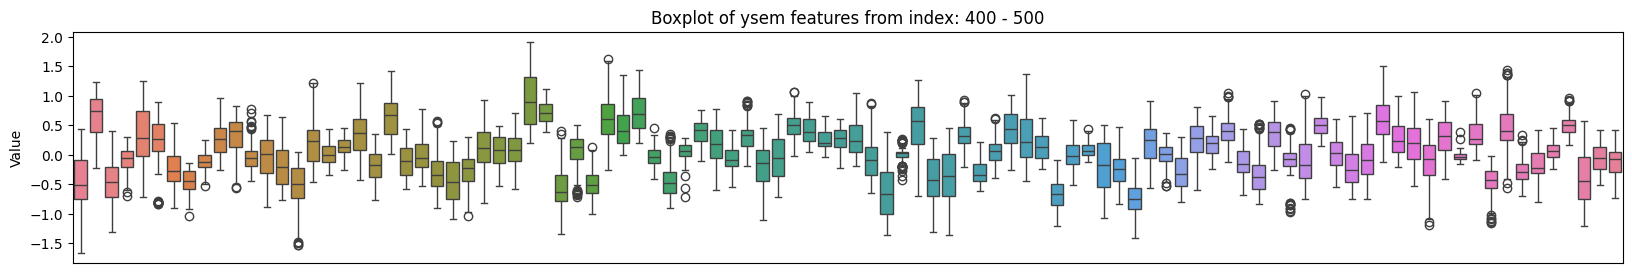

In [ ]:
df = pd.DataFrame(ysem.cpu().numpy(), columns=[f"{i}" for i in range(ysem.cpu().numpy().shape[1])])

for i in range(0, 500, 100):
    plt.figure(figsize=(20, 3))
    sns.boxplot(data=df.iloc[:, i:i+100])
    plt.title(f"Boxplot of ysem features from index: {i} - {i+100}")
    plt.xticks([])
    plt.xlabel("")
    plt.ylabel("Value")
    plt.show()


### train img anomaly prediction

In [79]:
# Get the encoded of x for train dataset

z_train = []

with torch.no_grad():
    for i, batch in enumerate(train_loader):
        if use_semantic:
            ysem = ema_encoder(x)
        else: 
            ysem = x
        recon, z = ocsvm.forward(ysem)
        z_train.append(z)

z_train = torch.cat(z_train)


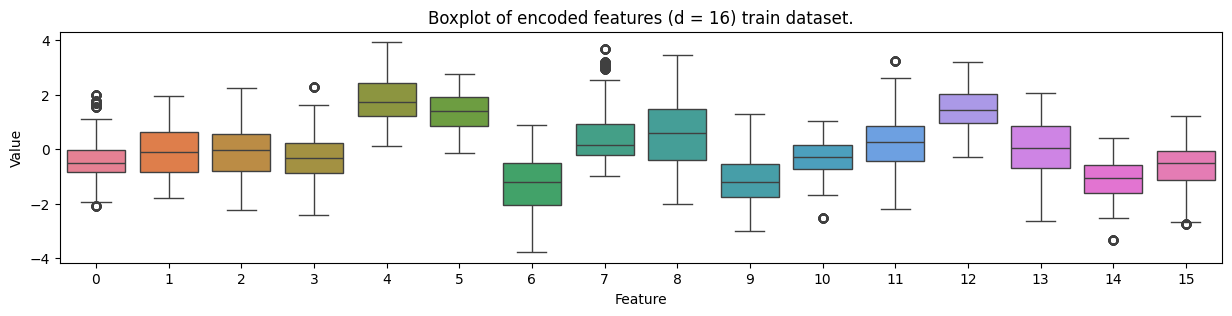

In [84]:
# plot boxplot of value of 16 dimensions of z_train
df = pd.DataFrame(z_train.cpu().numpy(), columns=[f"{i}" for i in range(z_train.cpu().numpy().shape[1])])

plt.figure(figsize=(15, 3))
sns.boxplot(data=df)
plt.title(f"Boxplot of encoded features (d = 16) train dataset.")
# plt.xticks([])
plt.xlabel("Feature")
plt.ylabel("Value")
plt.show()

In [90]:
# Predict outlier by oc-SVM

x_in = standardize(z_train)
pred_label = clf.predict(x_in.detach().cpu().numpy())

pos = (pred_label > 0).sum()
pos

1260

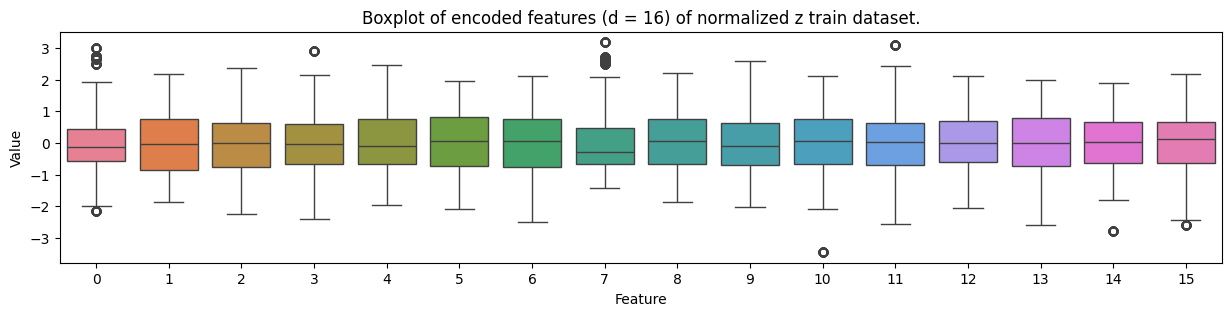

In [91]:
df = pd.DataFrame(x_in.cpu().numpy(), columns=[f"{i}" for i in range(x_in.cpu().numpy().shape[1])])

plt.figure(figsize=(15, 3))
sns.boxplot(data=df)
plt.title(f"Boxplot of encoded features (d = 16) of normalized z train dataset.")
# plt.xticks([])
plt.xlabel("Feature")
plt.ylabel("Value")
plt.show()

### pixel anomaly score

In [24]:
x0 = out_train["x_orgs"][:10]
# x0 = rearrange(x0, "b t ... -> (b t) ...")
x0.shape

torch.Size([10, 10, 1, 64, 64])

In [33]:
# Decode from random noise
# We need to sample from enough step to get good result
noise_level = 250

xhats = []

for i in range(x0.shape[0]): 
    x_T = gaussian_diffusion.q_sample(x0[i], t=noise_level)
    print(f"Denoise from random noise sample {i}")
    with torch.no_grad():
        x0_hat = gaussian_diffusion.representation_learning_diffae_sample(
            ddim_style="ddim10",
            encoder=ema_encoder,
            unet=ema_decoder,
            x_0=x0[i],
            x_T=x_T,
            start_t=noise_level,
            disable_tqdm=False
        )

        xhats.append(x0_hat)


Denoise from random noise sample 0


sampling loop time step: 100%|██████████| 10/10 [00:03<00:00,  3.11it/s]


Denoise from random noise sample 1


sampling loop time step: 100%|██████████| 10/10 [00:03<00:00,  2.71it/s]


Denoise from random noise sample 2


sampling loop time step: 100%|██████████| 10/10 [00:03<00:00,  2.64it/s]


Denoise from random noise sample 3


sampling loop time step: 100%|██████████| 10/10 [00:03<00:00,  2.53it/s]


Denoise from random noise sample 4


sampling loop time step: 100%|██████████| 10/10 [00:03<00:00,  2.57it/s]


Denoise from random noise sample 5


sampling loop time step: 100%|██████████| 10/10 [00:04<00:00,  2.40it/s]


Denoise from random noise sample 6


sampling loop time step: 100%|██████████| 10/10 [00:03<00:00,  2.54it/s]


Denoise from random noise sample 7


sampling loop time step: 100%|██████████| 10/10 [00:03<00:00,  2.92it/s]


Denoise from random noise sample 8


sampling loop time step: 100%|██████████| 10/10 [00:03<00:00,  2.79it/s]


Denoise from random noise sample 9


sampling loop time step: 100%|██████████| 10/10 [00:03<00:00,  2.87it/s]


In [40]:
xhats_all = torch.stack(xhats)

# Save results
torch.save(xhats_all, "./notebooks/exp_results/train_xhat.pt")

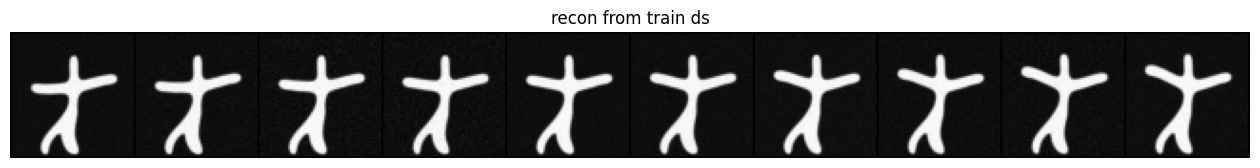

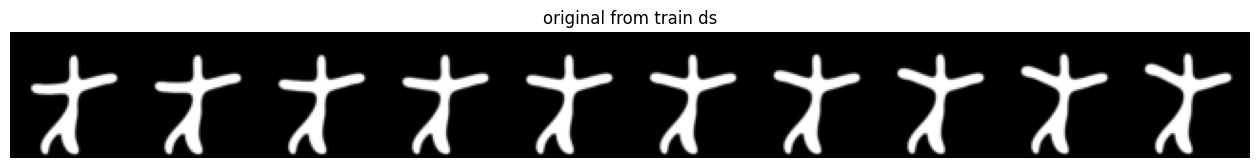

In [200]:
# Load result
xhats = torch.load("./notebooks/exp_results/train_xhat.pt")
xhats.shape

quick_plot_tensor(xhats[0], "recon from train ds")
quick_plot_tensor(x0[0], "original from train ds")

torch.Size([10, 1, 64, 64])

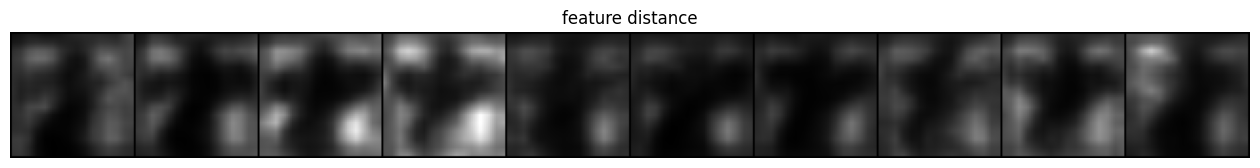

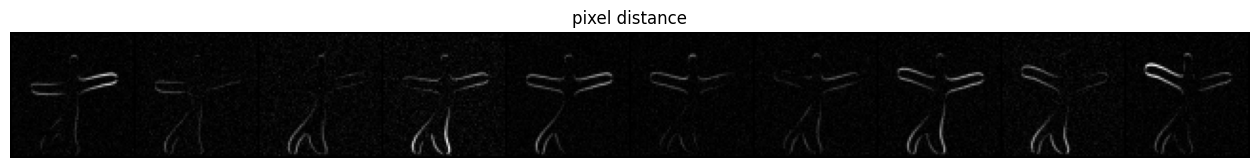

In [50]:
# Pixel anomaly score
ano_map, f_d, i_d = heat_map(
    xhats[0], x0[0], fe, v=7., fe_layers=["layer1", "layer2"]
)

quick_plot_tensor(f_d, "feature distance")
quick_plot_tensor(i_d, "pixel distance")

f_d.shape
i_d.shape

In [201]:
# Concat all ano_map, f_d and i_d for all xhats

f_ds = []
i_ds = []

for i in range(xhats.shape[0]):
    _, f_d, i_d = heat_map(
    xhats[i], x0[i], fe, v=7., fe_layers=["layer1", "layer2"]
    )

    f_ds.append(f_d)
    i_ds.append(i_d)

f_ds = torch.stack(f_ds)
i_ds = torch.stack(i_ds)

f_ds.shape

# concat f_d and i_d at each pixel
# each pixel will have 2 channels [f_d, i_d], i.e a vector dis \in R^2
distances = torch.cat((f_ds, i_ds), dim=2)
distances.shape

torch.Size([10, 10, 2, 64, 64])

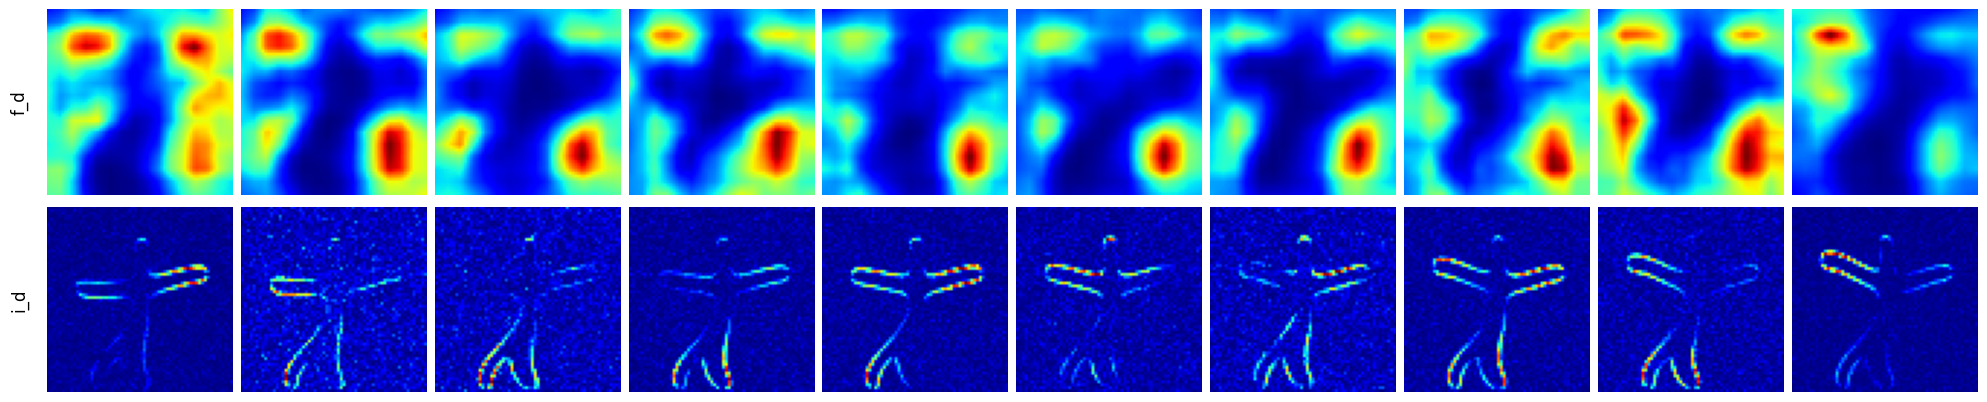

In [202]:
fig = plot_comparison_starmen(
    imgs=[f_ds[0].squeeze(), i_ds[0].squeeze()],
    labels=["f_d", "i_d"],
    is_errors=[True, True],
    same_cbar=False
)


In [308]:
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.preprocessing import StandardScaler


distances_train = rearrange(distances, "b t c h w -> (b t) c h w")
distances_train.shape
*_, h, w = distances_train.shape

clf_fits = {}

for i in range(h):
    for j in range(w): 
        scaler = StandardScaler()
        x_train = scaler.fit_transform(distances_train[:, :, i, j])
        clf_fit_pixel = svm.OneClassSVM(nu=0.03, gamma="scale").fit(x_train)

        key = (i, j)
        clf_fits[(i, j)] = {
            "scaler": scaler,
            "clf": clf_fit_pixel
        }

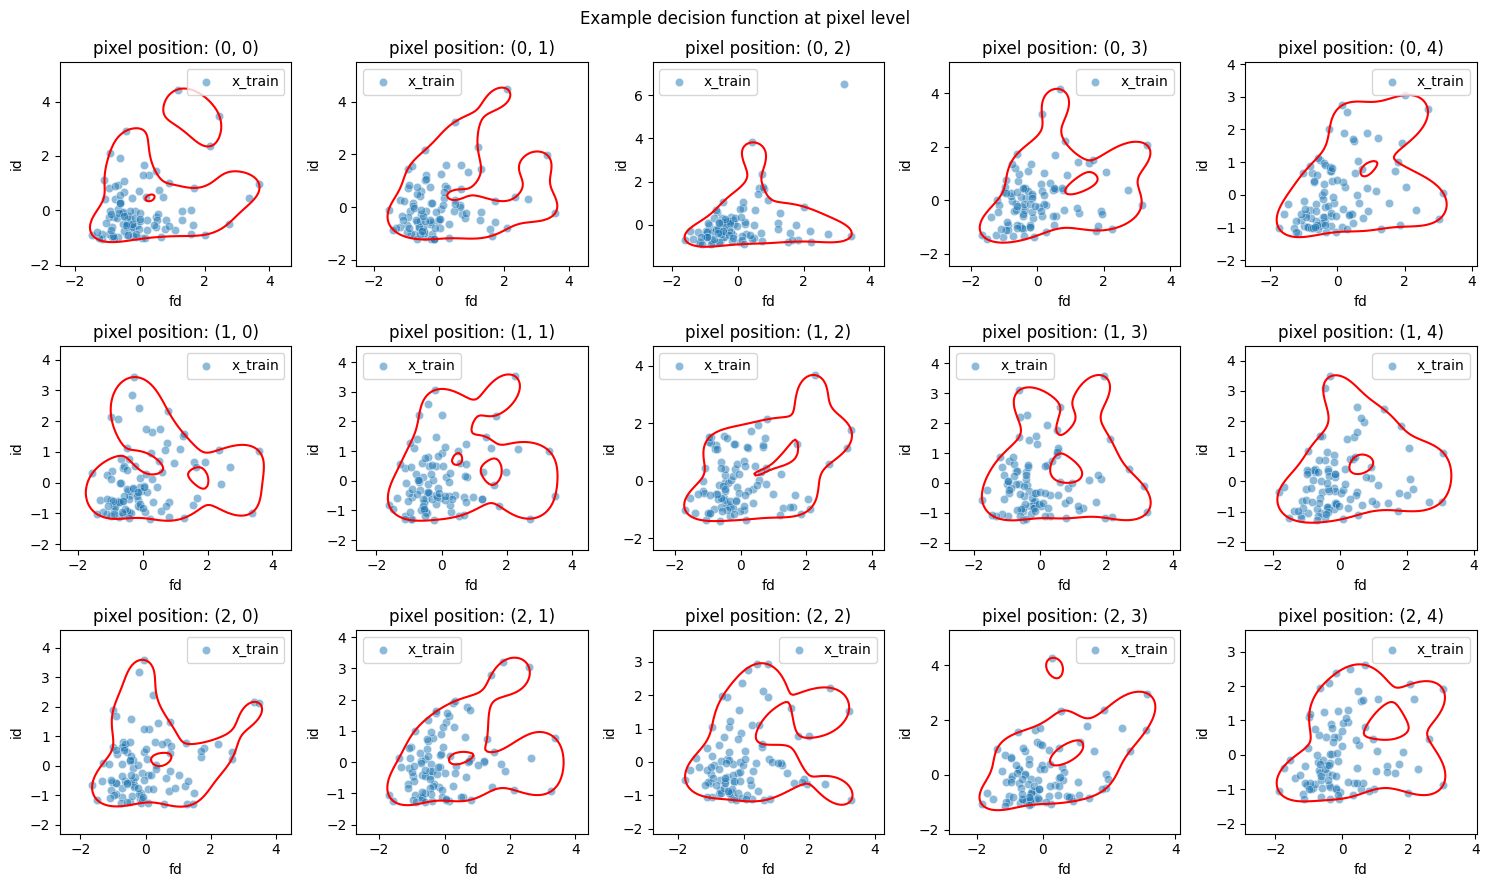

In [ ]:
# Plot decision boundary

# Scatter plot using Seaborn
fig, axes = plt.subplots(3, 5, figsize=(15, 9))

for i in range(3):
    for j in range(5):

        ax = axes[i, j]

        fit_dict = clf_fits[(i, j)]

        x_train = distances_train[:, :, i, j]
        x_train = fit_dict["scaler"].transform(x_train)

        estimator = fit_dict["clf"]

        df = pd.DataFrame(x_train, columns=["fd", "id"])
        sns.scatterplot(data=df, x="fd", y="id", alpha=0.5, ax=ax, label="x_train")
        ax.set_title(f"pixel position: {(i, j)}")
        DecisionBoundaryDisplay.from_estimator(
            estimator,
            x_train,
            response_method="decision_function",
            plot_method="contour",
            levels=[0],
            colors="red",
            ax=ax,
        )

plt.suptitle("Example decision function at pixel level")
plt.tight_layout()
plt.show()

## OC-SVM by ysem

In [241]:
ysem_train = ysem_dict["train"]
ysem_train.shape

clf = svm.OneClassSVM(nu=0.01, gamma="scale", verbose=True)
scaler = StandardScaler()

ysem_train_norm = scaler.fit_transform(ysem_train)
clf.fit(ysem_train_norm)

[LibSVM]*
optimization finished, #iter = 410
obj = 123.908382, rho = 3.585195
nSV = 132, nBSV = 22


,kernel,'rbf'
,degree,3
,gamma,'scale'
,coef0,0.0
,tol,0.001
,nu,0.01
,shrinking,True
,cache_size,200
,verbose,True
,max_iter,-1


In [242]:
pred_train = clf.predict(ysem_train_norm)
fp = (pred_train < 0).sum()
print(f"FP in training dataset: {fp}")

# Test dataset
ysem_test = scaler.transform(ysem_dict["test"])
pred_test = clf.predict(ysem_test)
fp = (pred_test < 0).sum()
print(f"FP in test dataset: {fp}")

# Anomaly dataset
ysem_dict.keys()
ano_keys = ['growing_circle', 'darker_circle', 'darker_line']
for k in ano_keys:
    ysem_ano = scaler.transform(ysem_dict[k])
    pred_ano = clf.predict(ysem_ano)
    fn = (pred_ano > 0).sum()
    print(f"FN in {k} dataset: {fn}")


FP in training dataset: 77
FP in test dataset: 97
FN in growing_circle dataset: 190
FN in darker_circle dataset: 189
FN in darker_line dataset: 199


In [262]:
# Effect of nu 
fp_test = []
fp_train = []
fn_ano = dict()
ano_keys = ['growing_circle', 'darker_circle', 'darker_line']
for k in ano_keys:
    fn_ano[k] = []

nu_grid = np.linspace(0.001, 0.1, 15)

for nu in nu_grid:
    clf = svm.OneClassSVM(nu=nu, gamma="scale", verbose=False)
    scaler = StandardScaler()

    ysem_train_norm = scaler.fit_transform(ysem_train)
    clf.fit(ysem_train_norm)

    # Train dataset
    pred_train = clf.predict(ysem_train_norm)
    fp = (pred_train < 1).sum()
    fp_train.append(fp)

    # Test dataset
    ysem_test = scaler.transform(ysem_dict["test"])
    pred_test = clf.predict(ysem_test)
    fp = (pred_test < 0).sum()
    # print(f"FP in test dataset: {fp}")
    fp_test.append(fp)

    # Anomaly dataset
    ysem_dict.keys()
    for k in ano_keys:
        ysem_ano = scaler.transform(ysem_dict[k])
        pred_ano = clf.predict(ysem_ano)
        fn = (pred_ano > 0).sum()
        # print(f"FN in {k} dataset: {fn}")
        fn_ano[k].append(fn)

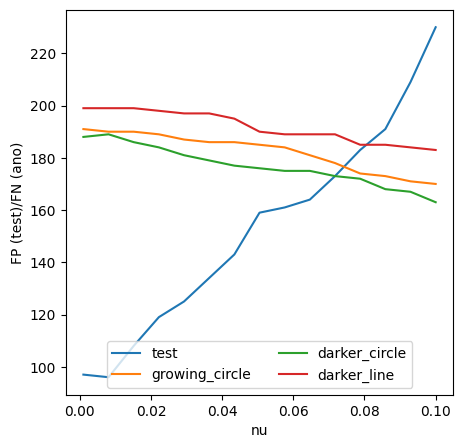

In [264]:
# Plot result
plt.figure(figsize=(5, 5))
plt.plot(nu_grid, fp_test, label="test")
# plt.plot(nu_grid, fp_train, label="train")
for k, v in fn_ano.items():
    plt.plot(nu_grid, v, label=k)
plt.xlabel("nu")
plt.ylabel("FP (test)/FN (ano)")
plt.legend(loc="lower center", ncol=2)
plt.show()

# Pixel-wise OC-SVM

### Load model

In [267]:
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.preprocessing import StandardScaler

import joblib
result_dir = "workdir/diffae_starmen/run-ocsvm"
clf_fits = joblib.load(os.path.join(result_dir, "ocsvm-fit-dict.pkl"))
print("Loaded OC-SVM fitted model.")

Loaded OC-SVM fitted model.


### train dataset

In [109]:
f_ds_train = torch.load("workdir/diffae_starmen/run-ocsvm/fd_train.pt", map_location=device)
i_ds_train = torch.load("workdir/diffae_starmen/run-ocsvm/id_train.pt", map_location=device)

# concat f_d and i_d at each pixel
# each pixel will have 2 channels [f_d, i_d], i.e a vector dis \in R^2
distances_train = torch.cat((f_ds_train, i_ds_train), dim=2)
distances_train.shape

distances_train = rearrange(distances_train, "b t c h w -> (b t) c h w")
distances_train.shape

torch.Size([7000, 2, 64, 64])

### test dataset

In [95]:
# Load dataset

out_test = load_test_dataset(split="test")
x0_test = out_test["x_orgs"]
# x0_test = rearrange(x0_test, "b t ... -> (b t) ...")

xhats_test = out_test["x_recons_semantic"]
# xhats_test = rearrange(xhats_test, "b t ... -> (b t) ...")
xhats_test.shape

Len of test dataset: 150


torch.Size([150, 10, 1, 64, 64])

In [96]:
# Pixel anomaly score

f_ds_test = []
i_ds_test = []

for i in range(xhats_test.shape[0]):
    _, f_d, i_d = heat_map(
    xhats_test[i], x0_test[i], fe, v=7., fe_layers=["layer1", "layer2"]
    )

    f_ds_test.append(f_d)
    i_ds_test.append(i_d)

f_ds_test = torch.stack(f_ds_test)
i_ds_test = torch.stack(i_ds_test)

f_ds_test.shape

# concat f_d and i_d at each pixel
# each pixel will have 2 channels [f_d, i_d], i.e a vector dis \in R^2
distances_test = torch.cat((f_ds_test, i_ds_test), dim=2)
distances_test.shape

distances_test = rearrange(distances_test, "b t c h w -> (b t) c h w")

In [97]:
# Save result
torch.save(f_ds_test, "workdir/diffae_starmen/run-ocsvm/fd_test.pt")
torch.save(i_ds_test, "workdir/diffae_starmen/run-ocsvm/id_test.pt")

In [108]:
# Load result
f_ds_test = torch.load("workdir/diffae_starmen/run-ocsvm/fd_test.pt")
i_ds_test = torch.load("workdir/diffae_starmen/run-ocsvm/id_test.pt")

# concat f_d and i_d at each pixel
# each pixel will have 2 channels [f_d, i_d], i.e a vector dis \in R^2
distances_test = torch.cat((f_ds_test, i_ds_test), dim=2)
distances_test.shape

distances_test = rearrange(distances_test, "b t c h w -> (b t) c h w")

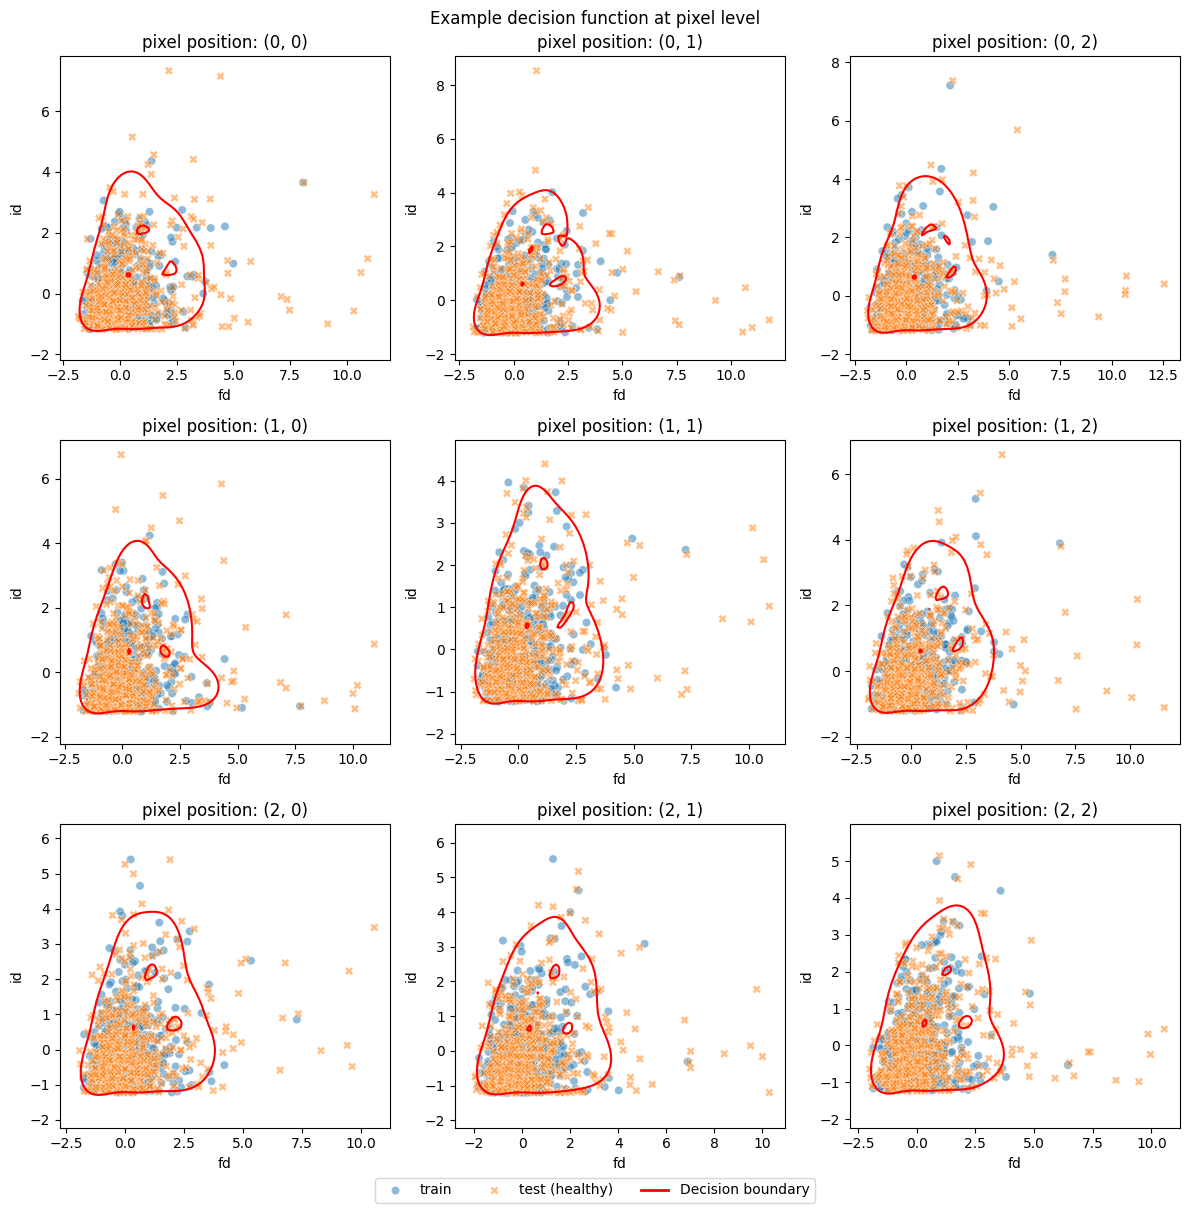

In [123]:
# Scatter plot using Seaborn
from matplotlib.lines import Line2D
fig, axes = plt.subplots(3, 3, figsize=(12, 12))

limit = 500

for i in range(3):
    for j in range(3):

        ax = axes[i, j]

        fit_dict = clf_fits[(i, j)]

        x_train = distances_train[:500, :, i, j]
        x_train = fit_dict["scaler"].transform(x_train)

        # x_test = fit_dict["scaler"].transform(distances_test[:, :, i, j])
        
        # use standard scaler
        x_test = distances_test[:, :, i, j]
        x_test = fit_dict["scaler"].transform(x_test)

        estimator = fit_dict["clf"]
        x_test_pred = estimator.predict(x_test)

        df = pd.DataFrame(x_train, columns=["fd", "id"])
        df["type"] = "train"

        df_test = pd.DataFrame(x_test, columns=["fd", "id"])
        df_test["type"] = "test (healthy)"
        df_test["pred"] = x_test_pred

        # # use standard scaler
        # x_test2 = StandardScaler().fit_transform(distances_test[:, :, i, j])
        # df_test2 = pd.DataFrame(x_test2, columns=["fd", "id"])
        # df_test2["type"] = "test-w-train-scaler"

        list_df = [df.iloc[:limit], 
                #    df_test,
                   df_test[df_test["pred"] == 1].iloc[:limit],
                   df_test[df_test["pred"] == -1],
                   ]
        df = pd.concat(list_df, ignore_index=True)

        sns.scatterplot(data=df, x="fd", y="id", alpha=0.5, ax=ax, hue="type", style="type")
        DecisionBoundaryDisplay.from_estimator(
            estimator,
            x_train,
            response_method="decision_function",
            plot_method="contour",
            levels=[0],
            colors="red",
            ax=ax,
        )
        ax.set_title(f"pixel position: {(i, j)}")

# Legends
handles, labels = axes[0, 0].get_legend_handles_labels()
for ax in axes.flat:
    ax.legend_.remove()
decision_legend = Line2D([0], [0], color='red', lw=2, label='Decision boundary')
handles.append(decision_legend)
labels.append("Decision boundary")

plt.suptitle("Example decision function at pixel level")
plt.tight_layout()
fig.legend(handles, labels, loc='lower center', ncol=len(labels), bbox_to_anchor=(0.5, -0.02))
plt.show()

In [216]:
ocsvm_test = joblib.load("workdir/diffae_starmen/run-ocsvm/ocsvm-test.pkl")
ocsvm_test.keys()

pixel_pred = ocsvm_test["pred"]
b, t, *_ = pixel_pred.shape

# Calculate the total of false positive pixel 
mask_fp = pixel_pred < 0 
fp_sum = mask_fp.sum(axis=(0, 1))
fp_sum.shape

fp_perc = fp_sum / np.full((64, 64), b * t)


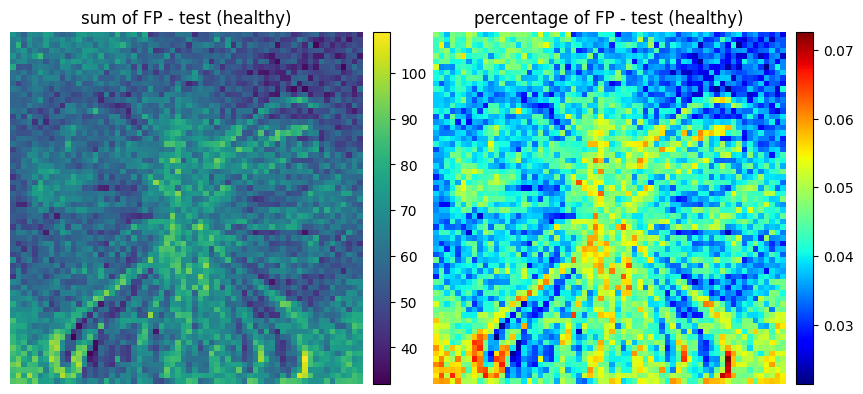

In [217]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

fig, axes = plt.subplots(1, 2, figsize=(10 ,5))

for ax in axes.flatten():
    ax.axis("off")

img_sum = axes[0].imshow(fp_sum, cmap="viridis")
axes[0].set_title("sum of FP - test (healthy)")
cax = inset_axes(axes[0],
                 width="5%",  # width = 5% of parent_bbox width
                 height="100%",  # height = 100% of parent_bbox height
                 loc='right',
                 bbox_to_anchor=(0.08, 0, 1, 1),
                 bbox_transform=axes[0].transAxes,
                 borderpad=0)
fig.colorbar(img_sum, cax=cax)


img_perc = axes[1].imshow(fp_perc, cmap="jet")
axes[1].set_title("percentage of FP - test (healthy)")
cax = inset_axes(axes[1],
                 width="5%",  # width = 5% of parent_bbox width
                 height="100%",  # height = 100% of parent_bbox height
                 loc='right',
                 bbox_to_anchor=(0.08, 0, 1, 1),
                 bbox_transform=axes[1].transAxes,
                 borderpad=0)
fig.colorbar(img_perc, cax=cax)

# plt.tight_layout()
plt.show()


### anomaly dataset

Len of darker_circle20 dataset: 20


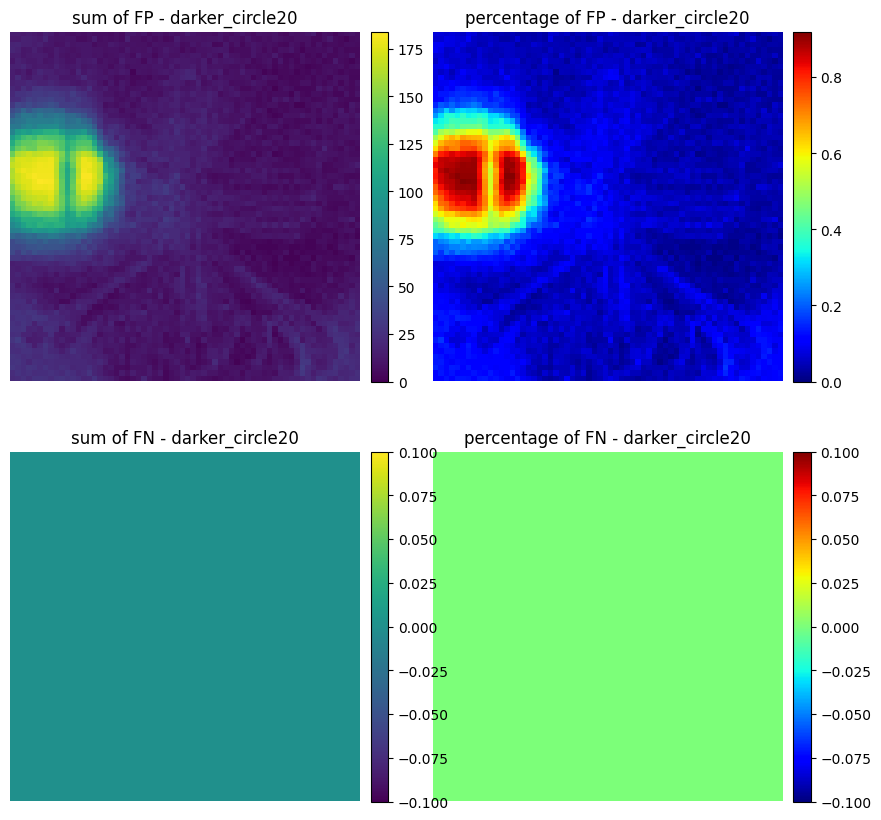

Len of darker_line20 dataset: 20


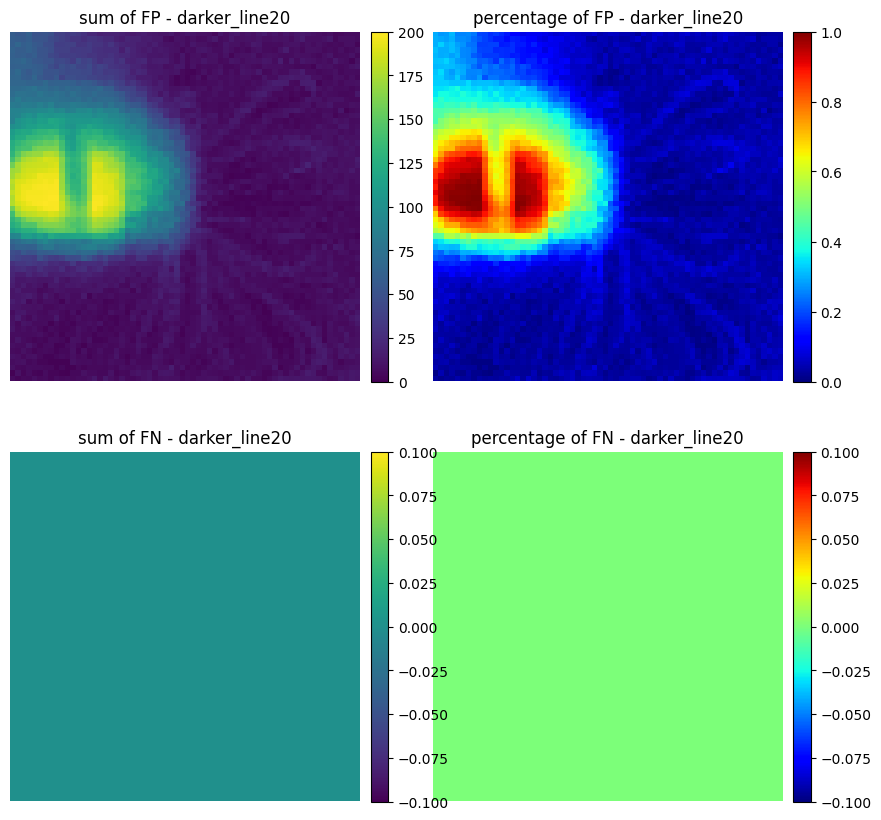

Len of growing_circle20 dataset: 20


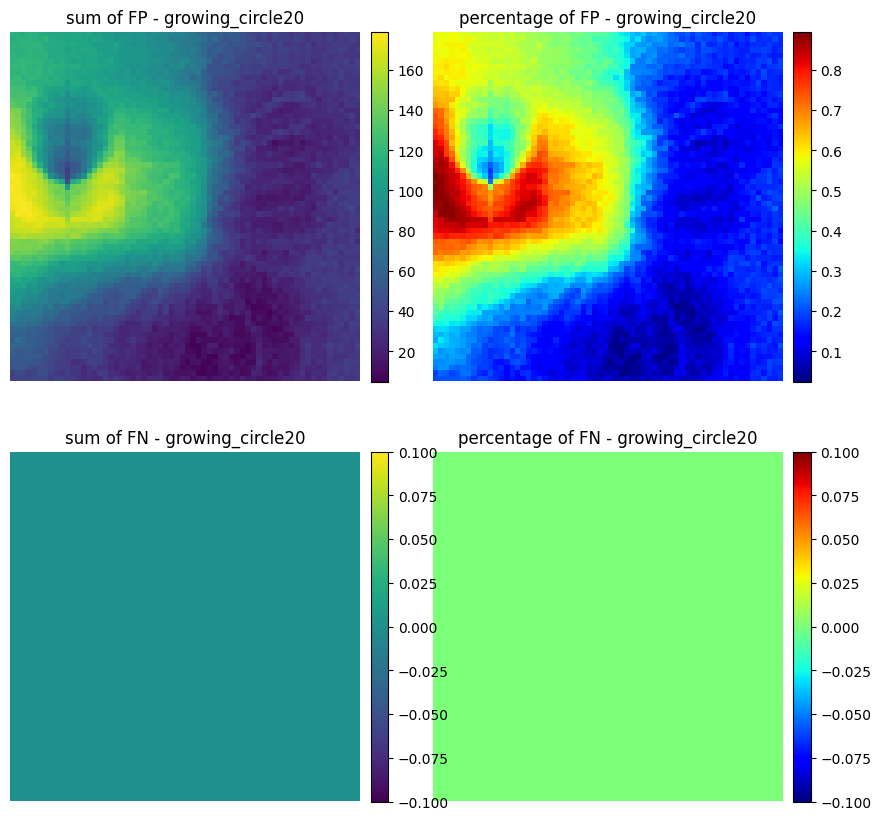

In [268]:
split = "darker_circle20"
splits = ["darker_circle20", "darker_line20", "growing_circle20"]

for split in splits: 

    ocsvm_ano = joblib.load(f"workdir/diffae_starmen/run-ocsvm/ocsvm-{split}.pkl")
    ocsvm_ano.keys()

    pixel_pred = ocsvm_ano["pred"]
    b, t, *_ = pixel_pred.shape

    # Get the anomaly ground truth segmentation
    out = load_test_dataset(split=split)
    ano_gts = out["x_ano_gts"]
    ano_gts = ano_gts.squeeze().numpy()

    # Mask false positive
    mask_fp = (pixel_pred < 0) & (ano_gts == 0)
    fp_sum = mask_fp.sum(axis=(0, 1))
    fp_sum.shape

    fp_perc = fp_sum / np.full((64, 64), b * t)

    # Mask false negative
    mask_fn = (pixel_pred > 0) & (ano_gts == 1.)
    fn_sum = mask_fn.sum(axis=(0, 1))
    fn_perc = fn_sum / np.full((64, 64), b * t)


    # Plot results ======================================
    fig, axes = plt.subplots(2, 2, figsize=(10 ,10))

    for ax in axes.flatten():
        ax.axis("off")

    # False Positive
    ax = axes[0, 0]
    img_sum = ax.imshow(fp_sum, cmap="viridis")
    ax.set_title(f"sum of FP - {split}")
    cax = inset_axes(ax,
                    width="5%",  # width = 5% of parent_bbox width
                    height="100%",  # height = 100% of parent_bbox height
                    loc='right',
                    bbox_to_anchor=(0.08, 0, 1, 1),
                    bbox_transform=ax.transAxes,
                    borderpad=0)
    fig.colorbar(img_sum, cax=cax)

    ax = axes[0, 1]
    img_perc = ax.imshow(fp_perc, cmap="jet")
    ax.set_title(f"percentage of FP - {split}")
    cax = inset_axes(ax,
                    width="5%",  # width = 5% of parent_bbox width
                    height="100%",  # height = 100% of parent_bbox height
                    loc='right',
                    bbox_to_anchor=(0.08, 0, 1, 1),
                    bbox_transform=ax.transAxes,
                    borderpad=0)
    fig.colorbar(img_perc, cax=cax)

    # False Negative
    ax = axes[1, 0]
    img_sum = ax.imshow(fn_sum, cmap="viridis")
    ax.set_title(f"sum of FN - {split}")
    cax = inset_axes(ax,
                    width="5%",  # width = 5% of parent_bbox width
                    height="100%",  # height = 100% of parent_bbox height
                    loc='right',
                    bbox_to_anchor=(0.08, 0, 1, 1),
                    bbox_transform=ax.transAxes,
                    borderpad=0)
    fig.colorbar(img_sum, cax=cax)

    ax = axes[1, 1]
    img_perc = ax.imshow(fn_perc, cmap="jet")
    ax.set_title(f"percentage of FN - {split}")
    cax = inset_axes(ax,
                    width="5%",  # width = 5% of parent_bbox width
                    height="100%",  # height = 100% of parent_bbox height
                    loc='right',
                    bbox_to_anchor=(0.08, 0, 1, 1),
                    bbox_transform=ax.transAxes,
                    borderpad=0)
    fig.colorbar(img_perc, cax=cax)

    # plt.tight_layout()
    plt.show()


# Pixel wise f_d and i_d

## f_d and i_d - train

In [7]:
# Load train f_d and i_d
f_ds_train = torch.load("workdir/diffae_starmen/run-ocsvm/fd_train.pt", map_location=device)
i_ds_train = torch.load("workdir/diffae_starmen/run-ocsvm/id_train.pt", map_location=device)

# concat f_d and i_d at each pixel
# each pixel will have 2 channels [f_d, i_d], i.e a vector dis \in R^2
distances_train = torch.cat((f_ds_train, i_ds_train), dim=2)
distances_train.shape

distances_train = rearrange(distances_train, "b t c h w -> (b t) c h w")
distances_train.shape

torch.Size([7000, 2, 64, 64])

## f_d and i_d - test

In [8]:
# Load train f_d and i_d
f_ds_test = torch.load("workdir/diffae_starmen/run-ocsvm/fd_test.pt", map_location=device)
i_ds_test = torch.load("workdir/diffae_starmen/run-ocsvm/id_test.pt", map_location=device)

# concat f_d and i_d at each pixel
# each pixel will have 2 channels [f_d, i_d], i.e a vector dis \in R^2
distances_test = torch.cat((f_ds_test, i_ds_test), dim=2)
distances_test.shape

distances_test = rearrange(distances_test, "b t c h w -> (b t) c h w")
distances_test.shape

torch.Size([1500, 2, 64, 64])

## f_d and i_d anomaly

In [67]:
fd_id_ano = dict()
splits = ['darker_circle20', 'darker_line20', 'growing_circle20']
for split in splits: 

    out = load_test_dataset(split=split)
    xhats_ano = out["x_recons_semantic"]
    x0_ano = out["x_orgs"]

    # Pixel anomaly score

    f_ds_ano = []
    i_ds_ano = []

    for i in range(xhats_ano.shape[0]):
        _, f_d, i_d = heat_map(
        xhats_ano[i], x0_ano[i], fe, v=7., fe_layers=["layer1", "layer2"]
        )

        f_ds_ano.append(f_d)
        i_ds_ano.append(i_d)

    f_ds_ano = torch.stack(f_ds_ano)
    i_ds_ano = torch.stack(i_ds_ano)

    f_ds_ano.shape

    # Get the groundtruth anomaly segmentation
    ano_gts = out["x_ano_gts"]
    fd_ano = f_ds_ano[ano_gts != 0.]
    fd_healthy = f_ds_ano[ano_gts == 0.]
    id_ano = i_ds_ano[ano_gts != 0.]
    id_healthy = i_ds_ano[ano_gts == 0.]

    # concat f_d and i_d at each pixel
    # each pixel will have 2 channels [f_d, i_d], i.e a vector dis \in R^2
    distances_ano = torch.cat((f_ds_ano, i_ds_ano), dim=2)
    distances_ano.shape

    distances_ano = rearrange(distances_ano, "b t c h w -> (b t) c h w")

    # write to dict
    result ={
        "fd_ano": fd_ano.cpu().numpy(),
        "fd_healthy": fd_healthy.cpu().numpy(),
        "id_ano": id_ano.cpu().numpy(),
        "id_healthy": id_healthy.cpu().numpy(), 
        "distances_ano": distances_ano.cpu().numpy()
    }
    fd_id_ano[split] = result

Len of darker_circle20 dataset: 20
Len of darker_line20 dataset: 20
Len of growing_circle20 dataset: 20


## Histogram comparison

In [72]:
from scipy.stats import gaussian_kde

fd_train = distances_train[:, 0, :, :].flatten()
counts, bin_edges = np.histogram(fd_train, bins=1000, density=False)
bin_centers_train = (bin_edges[:-1] + bin_edges[1:]) / 2
kde = gaussian_kde(bin_centers_train, weights=counts)
# x_eval = np.linspace(min(test), max(test), 1000)
pdf_train = kde(bin_centers_train)

In [ ]:
test2 = distances_test[:, 0, :, :].flatten()
test_counts, test_bin_edges = np.histogram(test2, bins=1000, density=False)
test_bin_centers = (test_bin_edges[:-1] + test_bin_edges[1:]) / 2
test_kde = gaussian_kde(test_bin_centers, weights=test_counts)

pdf_test = test_kde(test_bin_centers)


dict_keys(['darker_circle20', 'darker_line20', 'growing_circle20'])

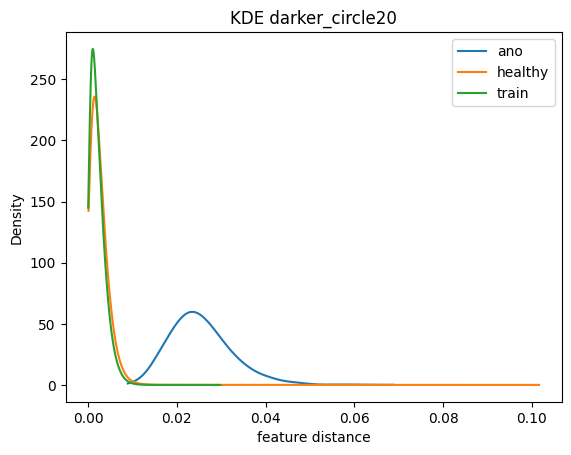

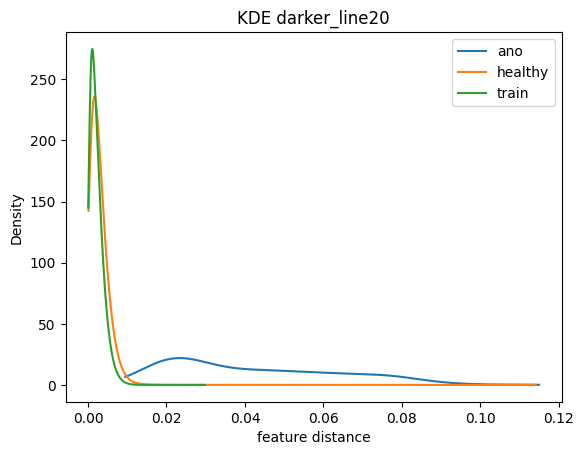

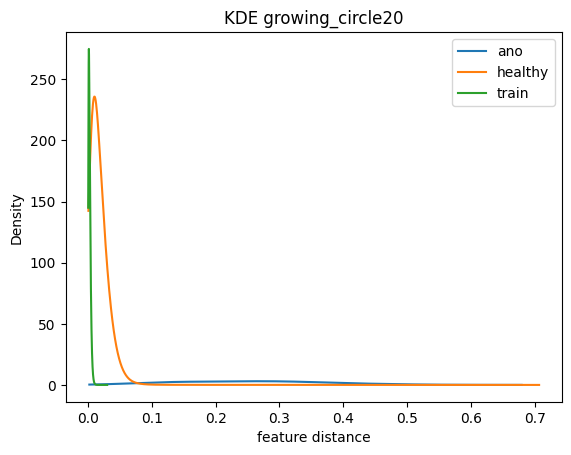

In [73]:
for k, v in fd_id_ano.items():
    counts_, bin_edges_ = np.histogram(v["fd_ano"], bins=1000, density=False)
    bin_centers_ = (bin_edges_[:-1] + bin_edges_[1:]) / 2
    kde_ = gaussian_kde(bin_centers_, weights=counts_)    
    fd_ano = kde_(bin_centers_)
    plt.plot(bin_centers_, fd_ano, label="ano")


    counts_, bin_edges_ = np.histogram(v["fd_healthy"], bins=1000, density=False)
    bin_centers_ = (bin_edges_[:-1] + bin_edges_[1:]) / 2
    kde_ = gaussian_kde(bin_centers_, weights=counts_)
    fd_healthy = kde_(bin_centers_)
    plt.plot(bin_centers_, pdf_test, label="healthy")

    plt.plot(bin_centers_train, pdf_train, label="train")

    plt.title(f"KDE {k}")
    plt.xlabel("feature distance")
    plt.ylabel("Density")
    plt.legend()
    plt.show()



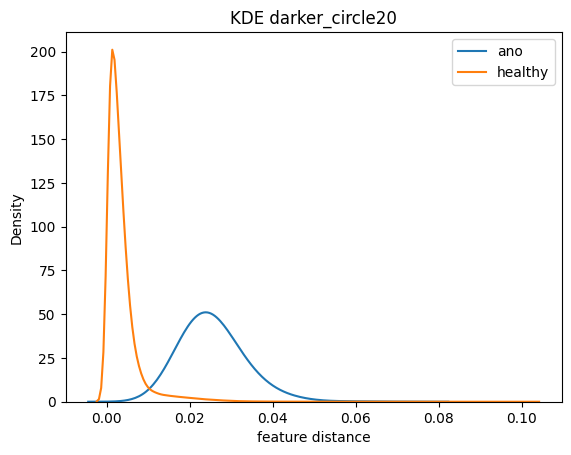

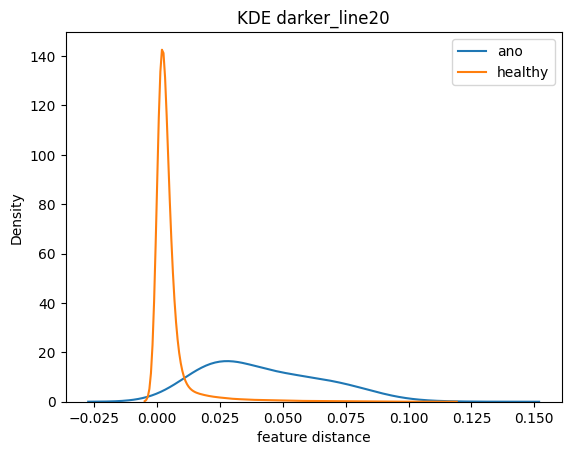

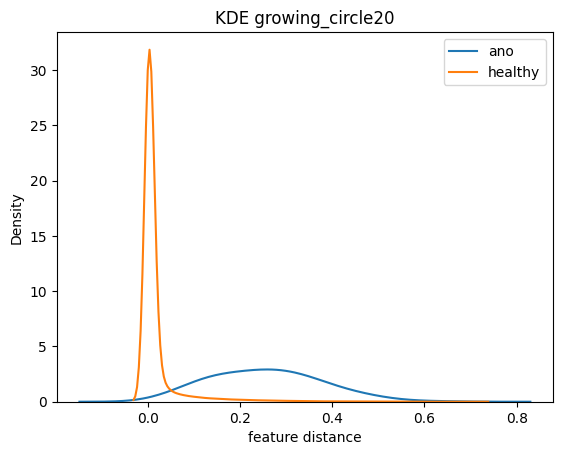

In [80]:
fd_train = distances_train[:, 0, :, :].flatten().cpu().numpy()

for k, v in fd_id_ano.items():
    sns.kdeplot(data=v["fd_ano"], bw_adjust=3, label="ano")
    sns.kdeplot(data=v["fd_healthy"], bw_adjust=3, label="healthy")
    # sns.kdeplot(data=fd_train, bw_adjust=3, label="train")
    plt.title(f"KDE {k}")
    plt.xlabel("feature distance")
    plt.ylabel("Density")
    plt.legend()
    plt.show()

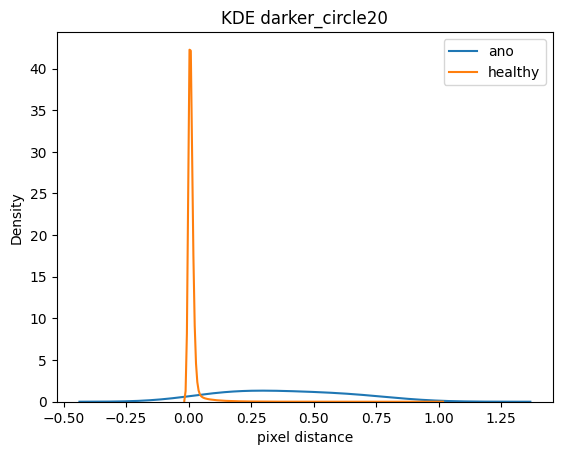

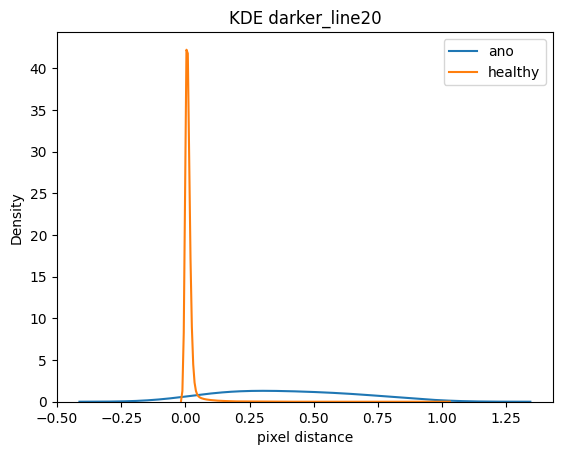

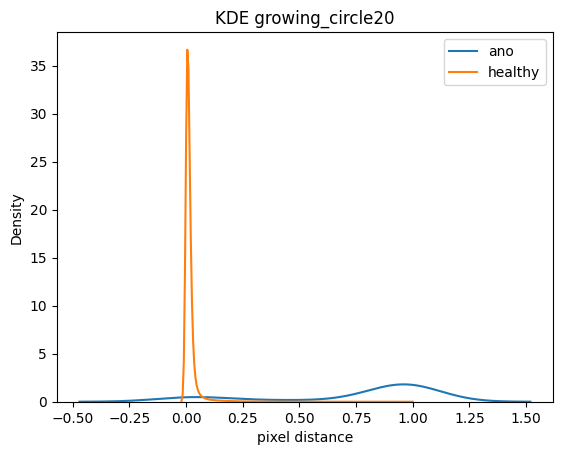

In [ ]:

for k, v in fd_id_ano.items():
    sns.kdeplot(data=v["id_ano"], bw_adjust=3, label="ano")
    sns.kdeplot(data=v["id_healthy"], bw_adjust=3, label="healthy")
    # sns.kdeplot(data=fd_train, bw_adjust=3, label="train")
    plt.title(f"KDE {k}")
    plt.xlabel("pixel distance")
    plt.ylabel("Density")
    plt.legend()
    plt.show()

<Axes: xlabel='f_d', ylabel='Percent'>

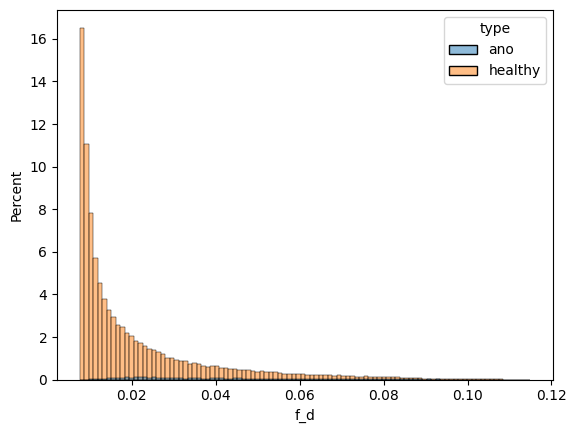

In [134]:
# sns.histplot(data=fd_id_ano["growing_circle20"]["fd_ano"], label="ano")
split = "darker_line20"
df1 = pd.DataFrame(fd_id_ano[split]["fd_ano"], columns=["f_d"])
df1["type"] = "ano"

df2 = pd.DataFrame(fd_id_ano[split]["fd_healthy"], columns=["f_d"])
df2["type"] = "healthy"

df = pd.concat([df1, df2], axis=0)
df.head()

fd_train = distances_train[:, 0, :, :].flatten().cpu().numpy()
fd_train_99pct = np.percentile(fd_train, q=99.)
sns.histplot(data=df[df["f_d"] > fd_train_99pct], x="f_d", bins=100, hue="type", stat="percent")


<Axes: xlabel='i_d', ylabel='Percent'>

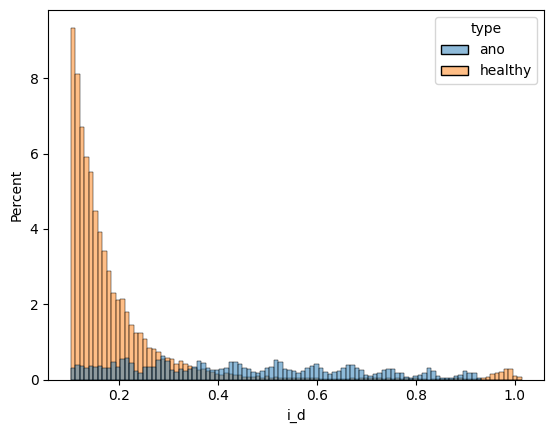

In [135]:
# sns.histplot(data=fd_id_ano["growing_circle20"]["fd_ano"], label="ano")
df1 = pd.DataFrame(fd_id_ano[split]["id_ano"], columns=["i_d"])
df1["type"] = "ano"

df2 = pd.DataFrame(fd_id_ano[split]["id_healthy"], columns=["i_d"])
df2["type"] = "healthy"

df = pd.concat([df1, df2], axis=0)
df.head()

fd_train = distances_train[:, 1, :, :].flatten().cpu().numpy()
fd_train_99pct = np.percentile(fd_train, q=99.)
sns.histplot(data=df[df["i_d"] > fd_train_99pct], x="i_d", bins=100, hue="type", stat="percent")

## v parameters

In [204]:
from src.utils.metrics import compute_prc, compute_roc


def combine_fd_id(f_d, i_d, v, use_gaussian_blur=True, sigma=4):
    from kornia.filters import gaussian_blur2d
    # combine i_d and f_d to generate anomaly_map
    anomaly_map = 0
    kernel_size = 2 * int(4 * sigma + 0.5) +1

    anomaly_map += f_d + v * (f_d.max()/ i_d.max()) * i_d  
    if use_gaussian_blur:
        anomaly_map = gaussian_blur2d(
            anomaly_map , kernel_size=(kernel_size,kernel_size), sigma=(sigma,sigma)
            )
    anomaly_map = torch.sum(anomaly_map, dim=1).unsqueeze(1)
    return anomaly_map, f_d, i_d


In [185]:
v_grid = np.linspace(0., 10., 10)

auroc_ls = []
auprc_ls = []

for v_param in v_grid: 
    img_score_all = []
    img_labels_true = []

    # Test (healthy) dataset
    fd = distances_test[:, 0, :, :]
    id = distances_test[:, 1, :, :]

    img_labels_true.extend([0] * fd.shape[0])

    fd = fd.unsqueeze(1)
    id = id.unsqueeze(1)
    anomap, *_ = combine_fd_id(fd, id ,v=v_param)

    img_score = np.max(anomap.cpu().numpy(), axis=(1, 2, 3))
    img_score_all.extend(img_score)

    # Anomaly dataset
    for k, v in fd_id_ano.items():
        fd = v["distances_ano"][:, 0, :, :]
        id = v["distances_ano"][:, 1, :, :]

        fd = to_torch(fd).unsqueeze(1)
        id = to_torch(id).unsqueeze(1)

        img_labels_true.extend([1] * fd.shape[0])
        
        anomap, *_ = combine_fd_id(fd, id ,v=v_param)
        
        img_score = np.max(anomap.cpu().numpy(), axis=(1, 2, 3))
        img_score_all.extend(img_score)

    # AUPRC, AUROC
    img_score_all = np.array(img_score_all)
    img_labels_true = np.array(img_labels_true)

    AUROC, _fpr, _tpr, _threshs = compute_roc(img_score_all, img_labels_true)
    AUPRC, _precisions, _recalls, _threshs = compute_prc(img_score_all, img_labels_true)

    auroc_ls.append(AUROC)
    auprc_ls.append(AUPRC)

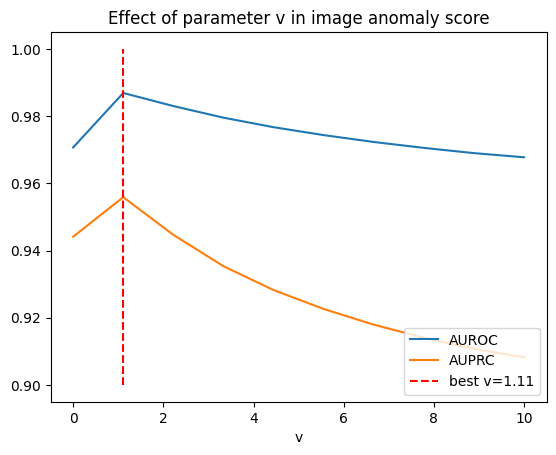

In [203]:
# Plot
best_v = v_grid[np.argmax(auprc_ls)]
plt.plot(v_grid, auroc_ls, label="AUROC")
plt.plot(v_grid, auprc_ls, label="AUPRC")
plt.title("Effect of parameter v in image anomaly score")
plt.vlines(best_v, ymin=0.9, ymax=1.0, color="red", linestyles="--", label=f"best v={best_v:.2f}")
plt.xlabel("v")
plt.legend(loc="lower right")
plt.show()

## Threshold quantile q

In [ ]:
# Train dataset

ano_map_train = []
for i in range(f_ds_train.shape[0]):
    fd = f_ds_train[i]
    id = i_ds_train[i]
    anomap, *_ = combine_fd_id(fd, id, v=1.5)
    ano_map_train.append(anomap)

ano_map_train = torch.stack(ano_map_train)
ano_map_train.shape

img_score_train = np.max(ano_map_train.cpu().numpy(), axis=(1, 2, 3, 4))
img_99pct = np.percentile(img_score_train, 99)

# Thresholding with test+ano dataset
img_score_thres = (img_score_all > img_99pct).astype(int)
